## 数据下载

In [1]:
import akshare as ak
import pandas as pd
import os
from tqdm import tqdm
import numpy as np

raw_data_dir = "etf_data_raw"
processed_data_dir = "etf_data_processed"
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(processed_data_dir, exist_ok=True)

start_date = pd.to_datetime("2018-06-19")
end_date   = pd.to_datetime("2024-12-31")

tickers = ['DIA', 'IWM', 'QQQ', 'SPY', 'VXX',
           'XLB', 'XLC', 'XLE', 'XLF', 'XLI',
           'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']

etf_data = {}
for ticker in tqdm(tickers):
    try:
        df = ak.stock_us_daily(symbol=ticker)
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

        df.to_csv(os.path.join(raw_data_dir, f"{ticker}_raw.csv"), index=False)

        df_simple = df[['date', 'open', 'close', 'high','low','volume']].copy()
        df_simple.columns = ['date', f'{ticker}_open', f'{ticker}_close', f'{ticker}_high',f'{ticker}_low',f'{ticker}_volume']
        etf_data[ticker] = df_simple

    except Exception as e:
        print(f"[ERROR] 下载失败：{ticker}，原因：{e}")

merged_df = etf_data[tickers[0]]
for ticker in tickers[1:]:
    merged_df = pd.merge(merged_df, etf_data[ticker], on='date', how='outer')

merged_df = merged_df.sort_values('date').reset_index(drop=True)

# 空值统计
null_counts_by_column = merged_df.isna().sum()
print("\n缺失值统计（按列）")
print(null_counts_by_column)

null_counts_by_etf = {
    t: merged_df[[f"{t}_open", f"{t}_close", f"{t}_volume"]].isna().any(axis=1).sum()
    for t in tickers
}
print("\n缺失值统计（按ETF）")
for t, n in null_counts_by_etf.items():
    print(f"{t}: {n} 条记录缺失")

rows_before = len(merged_df)
clean_df    = merged_df.dropna()
rows_after  = len(clean_df)
print(f"\n删除缺失行前：{rows_before} 行；删除后：{rows_after} 行；共删除 {rows_before - rows_after} 行。")


merged_df.to_csv(os.path.join(processed_data_dir, "etf_daily_data_2015_2024.csv"), index=False)
clean_df.to_csv(os.path.join(processed_data_dir, "etf_daily_data_2015_2024_clean.csv"), index=False)

print("\n已保存：")
print("合并原始文件: etf_daily_data_2015_2024.csv")
print("缺失值清洗后: etf_daily_data_2015_2024_clean.csv")
print("每只 ETF 原始 CSV 位于 etf_data_raw目录")

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]



缺失值统计（按列）
date          0
DIA_open      1
DIA_close     1
DIA_high      1
DIA_low       1
             ..
XLY_open      1
XLY_close     1
XLY_high      1
XLY_low       1
XLY_volume    1
Length: 81, dtype: int64

缺失值统计（按ETF）
DIA: 1 条记录缺失
IWM: 1 条记录缺失
QQQ: 0 条记录缺失
SPY: 1 条记录缺失
VXX: 65 条记录缺失
XLB: 1 条记录缺失
XLC: 871 条记录缺失
XLE: 1 条记录缺失
XLF: 1 条记录缺失
XLI: 1 条记录缺失
XLK: 1 条记录缺失
XLP: 1 条记录缺失
XLRE: 200 条记录缺失
XLU: 1 条记录缺失
XLV: 1 条记录缺失
XLY: 1 条记录缺失

删除缺失行前：2516 行；删除后：1581 行；共删除 935 行。

已保存：
合并原始文件: etf_daily_data_2015_2024.csv
缺失值清洗后: etf_daily_data_2015_2024_clean.csv
每只 ETF 原始 CSV 位于 etf_data_raw目录


## 构建特征工程 + 标准化

In [2]:
features_df = clean_df[['date']].copy()

for ticker in tickers:
    df = clean_df[['date',
                   f'{ticker}_open', f'{ticker}_high', f'{ticker}_low',
                   f'{ticker}_close', f'{ticker}_volume']].copy()

    # 收益率 return
    df[f'{ticker}_return'] = df[f'{ticker}_close'].pct_change()

    # 振幅 = (high - low)/open
    df[f'{ticker}_amplitude'] = (df[f'{ticker}_high'] - df[f'{ticker}_low']) / df[f'{ticker}_open']

    # 尾盘强度 = (close - open)/open
    df[f'{ticker}_tail_strength'] = (df[f'{ticker}_close'] - df[f'{ticker}_open']) / df[f'{ticker}_open']

    # 对数成交量（缩放）
    df[f'{ticker}_log_volume'] = np.log1p(df[f'{ticker}_volume'])

    features_df = pd.merge(features_df, df[[
        'date',
        f'{ticker}_return',
        f'{ticker}_amplitude',
        f'{ticker}_tail_strength',
        f'{ticker}_log_volume'
    ]], on='date')

features_df = features_df.dropna().reset_index(drop=True)

features_df.to_csv(os.path.join(processed_data_dir, "etf_feature_matrix.csv"), index=False)
print("多指标特征表保存：etf_feature_matrix.csv")

feature_cols = [col for col in features_df.columns if col != 'date']
target_cols = [f"{ticker}_return" for ticker in tickers]

data_array = features_df[feature_cols].values
target_array = features_df[target_cols].values

window = 7
X_static, Y_static = [], []
X_seq, Y_seq = [], []

for i in range(window, len(data_array) - 1):
    # 静态结构
    X_static.append(data_array[i - window:i].flatten())
    Y_static.append(target_array[i + 1])

    # 序列结构
    X_seq.append(data_array[i - window:i])
    Y_seq.append(target_array[i + 1])

# 转换为 DataFrame / ndarray
flattened_feature_names = []
for t in range(-window, 0): 
    for feat in feature_cols:
        flattened_feature_names.append(f"t{t}_{feat}")

X_static = pd.DataFrame(X_static, columns=flattened_feature_names)
Y_static = pd.DataFrame(Y_static, columns=target_cols)

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

from sklearn.preprocessing import StandardScaler
import joblib

# 归一化Static
scaler_static = StandardScaler()
X_static_scaled = scaler_static.fit_transform(X_static)

X_static_scaled_df = pd.DataFrame(X_static_scaled, columns=X_static.columns)
X_static_scaled_df.to_csv(os.path.join(processed_data_dir, "X_static_window7_scaled.csv"), index=False)
Y_static.to_csv(os.path.join(processed_data_dir, "Y_static_window7.csv"), index=False)
joblib.dump(scaler_static, os.path.join(processed_data_dir, "scaler_static.pkl"))

# 归一化Sequence
n_samples, time_steps, n_features = X_seq.shape
X_seq_reshaped = X_seq.reshape(n_samples, -1)

scaler_seq = StandardScaler()
X_seq_scaled = scaler_seq.fit_transform(X_seq_reshaped)

X_seq_scaled = X_seq_scaled.reshape(n_samples, time_steps, n_features)

np.save(os.path.join(processed_data_dir, "X_sequence_window7_scaled.npy"), X_seq_scaled)
np.save(os.path.join(processed_data_dir, "Y_sequence_window7.npy"), Y_seq)
joblib.dump(scaler_seq, os.path.join(processed_data_dir, "scaler_seq.pkl"))

print("已保存静态和序列特征工程")

多指标特征表保存：etf_feature_matrix.csv
已保存静态和序列特征工程


## VAR

Return 矩阵读取完成
ADF 检验完成并保存
VAR 模型训练与预测完成，预测结果和模型已保存


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


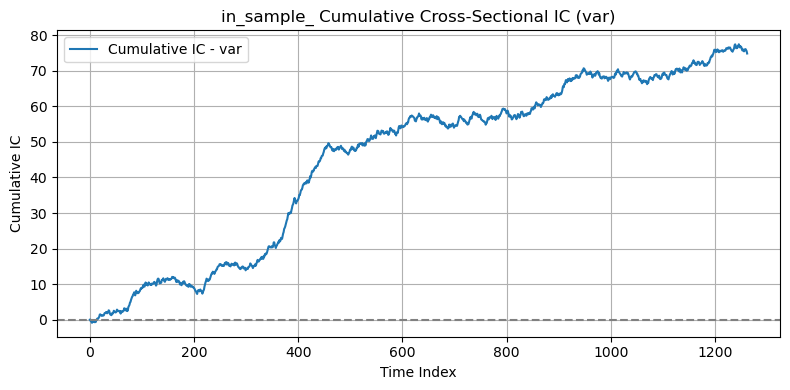

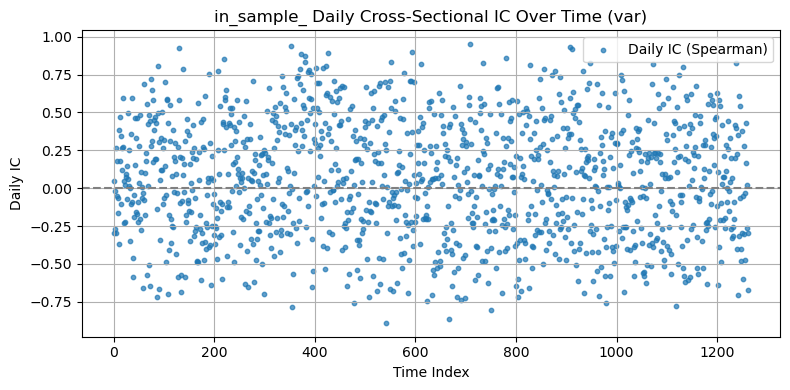

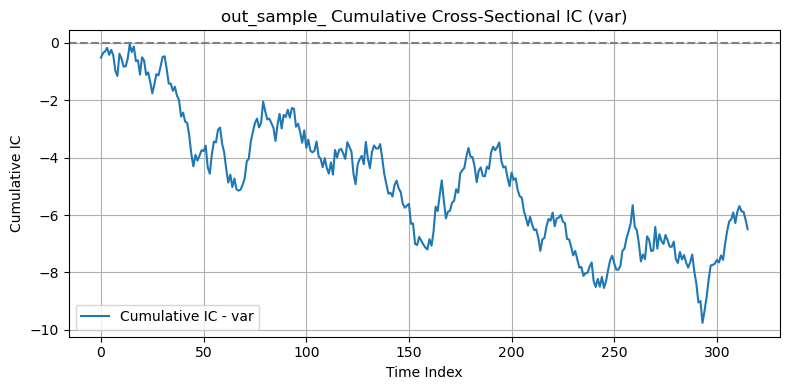

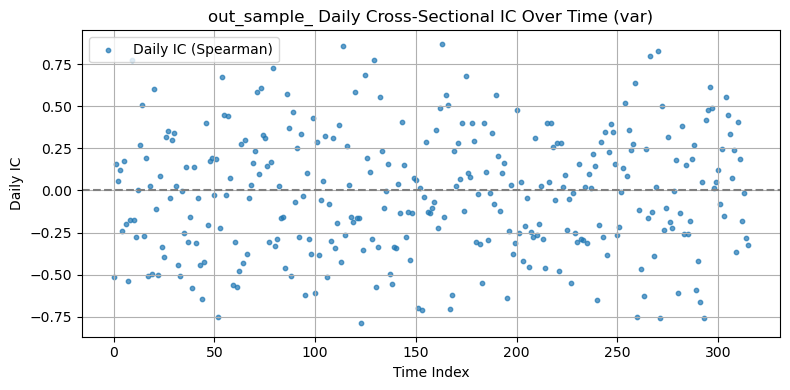

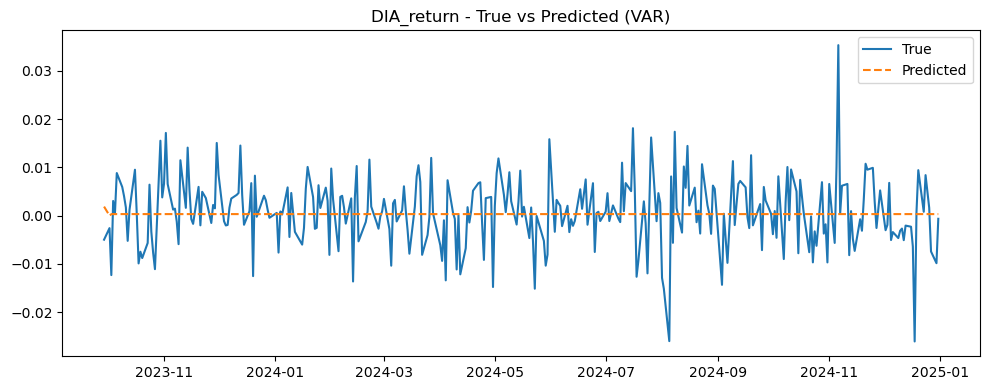

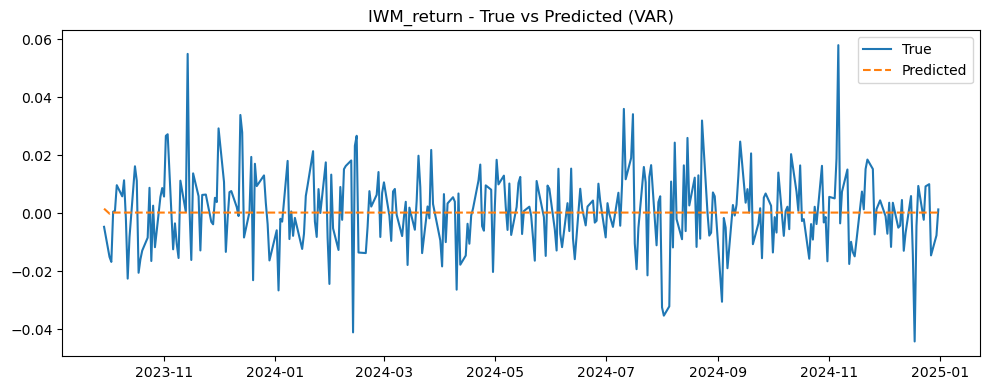

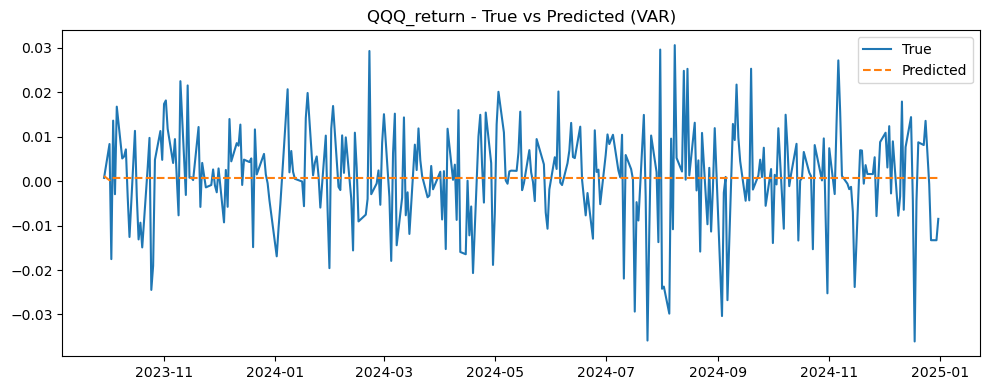

VAR分析完成，结果已保存etf_data_processed/var_result


In [3]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import joblib

var_data_dir = "etf_data_processed/var_result"
os.makedirs(var_data_dir, exist_ok=True)
return_matrix_path = os.path.join(processed_data_dir, "etf_feature_matrix.csv")
save_model_path = os.path.join(var_data_dir, "var_model.pkl")
save_pred_path = os.path.join(var_data_dir, "var_prediction.csv")

# 提取 return 矩阵
def extract_return_matrix(csv_path, tickers):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    return_cols = [f"{ticker}_return" for ticker in tickers]
    return df[['date'] + return_cols].dropna().reset_index(drop=True)

# ADF 检验
def check_adf_stationarity(return_df):
    adf_result = {}
    for col in return_df.columns:
        if col == 'date':
            continue
        result = adfuller(return_df[col])
        adf_result[col] = {
            'ADF Statistic': result[0],
            'p-value': result[1],
            'Is Stationary': result[1] < 0.05
        }
    return pd.DataFrame(adf_result).T

# VAR 训练预测
def fit_var_model(return_df, test_size=0.2, lags=1):
    df = return_df.set_index('date')
    n_test = int(len(df) * test_size)
    train_df_var = df.iloc[:-n_test]
    test_df_var = df.iloc[-n_test:]

    model_var = VAR(train_df_var)
    results_var = model_var.fit(lags)

    forecast_var = results_var.forecast(train_df_var.values[-lags:], steps=len(test_df_var))
    forecast_df_var = pd.DataFrame(forecast_var, index=test_df_var.index, columns=train_df_var.columns)
    return results_var, forecast_df_var, test_df_var, train_df_var

# IC评估
def evaluate_ic_metrics(pred_df, true_df, save_dir, model_name="model", prefix=""):
    ic_list = []
    for i in range(len(pred_df)):
        pred = pred_df.iloc[i]
        true = true_df.iloc[i]
        ic, _ = spearmanr(pred, true)
        ic_list.append(ic)

    ic_series = pd.Series(ic_list).dropna()
    cum_ic = ic_series.cumsum()

    # 可视化：累计 IC 曲线
    plt.figure(figsize=(8, 4))
    plt.plot(cum_ic, label=f'Cumulative IC - {model_name}')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{prefix} Cumulative Cross-Sectional IC ({model_name})")
    plt.xlabel("Time Index")
    plt.ylabel("Cumulative IC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{prefix}{model_name}_cum_ic.png"))
    plt.show()
    plt.close()

    # 可视化：原始 IC 序列图
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(ic_series)), ic_series, s=10, label='Daily IC (Spearman)', alpha=0.7)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{prefix} Daily Cross-Sectional IC Over Time ({model_name})")
    plt.xlabel("Time Index")
    plt.ylabel("Daily IC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{prefix}{model_name}_daily_ic.png"))
    plt.show()
    plt.close()

    # 统计指标
    mean_ic = ic_series.mean()
    std_ic = ic_series.std()
    ir_ic = mean_ic / std_ic if std_ic > 0 else np.nan
    pos_ratio = (ic_series > 0).mean()

    with open(os.path.join(save_dir, f"{prefix}{model_name}_ic_stats.txt"), 'w') as f:
        f.write(f"{prefix}_var_ic_stats\n")
        f.write(f"Mean IC: {mean_ic:.4f}\n")
        f.write(f"Std  IC: {std_ic:.4f}\n")
        f.write(f"IC IR  : {ir_ic:.4f}\n")
        f.write(f"Positive IC Ratio: {pos_ratio:.2%}\n")

    cum_ic.to_csv(os.path.join(save_dir, f"{prefix}{model_name}_cum_ic.csv"), index=False)
    return ic_series, cum_ic

if __name__ == '__main__':
    return_df_var = extract_return_matrix(return_matrix_path, tickers)
    print("Return 矩阵读取完成")

    adf_df_var = check_adf_stationarity(return_df_var)
    adf_df_var.to_csv(os.path.join(var_data_dir, "var_adf_result.csv"))
    print("ADF 检验完成并保存")

    model_var, pred_df_var, test_df_var, train_df_var = fit_var_model(return_df_var, test_size=0.2, lags=1)
    pred_df_var.to_csv(save_pred_path)
    joblib.dump(model_var, save_model_path)
    print("VAR 模型训练与预测完成，预测结果和模型已保存")

    # 样本内 IC
    evaluate_ic_metrics(
        pred_df=model_var.fittedvalues,
        true_df=train_df_var.iloc[model_var.k_ar:],
        save_dir=var_data_dir,
        model_name="var",
        prefix="in_sample_"
    )

    # 样本外 IC
    ic_series_var, cum_ic_var = evaluate_ic_metrics(
        pred_df=pred_df_var,
        true_df=test_df_var,
        save_dir=var_data_dir,
        model_name="var",
        prefix="out_sample_"
    )

    for col in pred_df_var.columns[:3]:
        plt.figure(figsize=(10, 4))
        plt.plot(pred_df_var.index, test_df_var[col], label="True", linewidth=1.5)
        plt.plot(pred_df_var.index, pred_df_var[col], label="Predicted", linestyle="--")
        plt.title(f"{col} - True vs Predicted (VAR)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    mse_var, mae_var = {}, {}
    for col in pred_df_var.columns:
        mse_var[col] = mean_squared_error(test_df_var[col], pred_df_var[col])
        mae_var[col] = mean_absolute_error(test_df_var[col], pred_df_var[col])

    error_df_var = pd.DataFrame({'MSE': mse_var, 'MAE': mae_var})
    error_df_var.to_csv(os.path.join(var_data_dir, "var_error_metrics.csv"))
    print(f"VAR分析完成，结果已保存{var_data_dir}")


## MLP

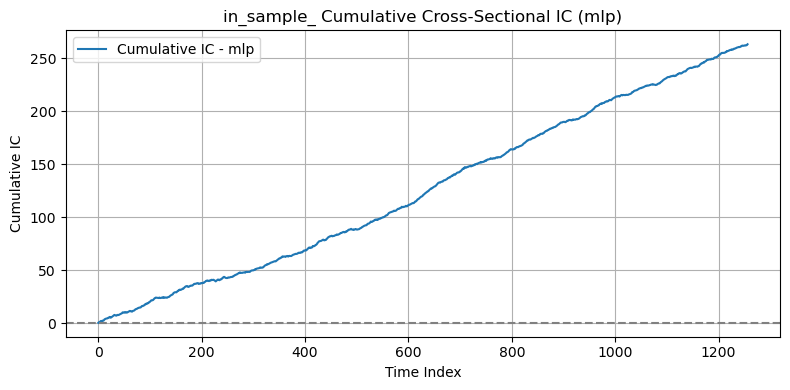

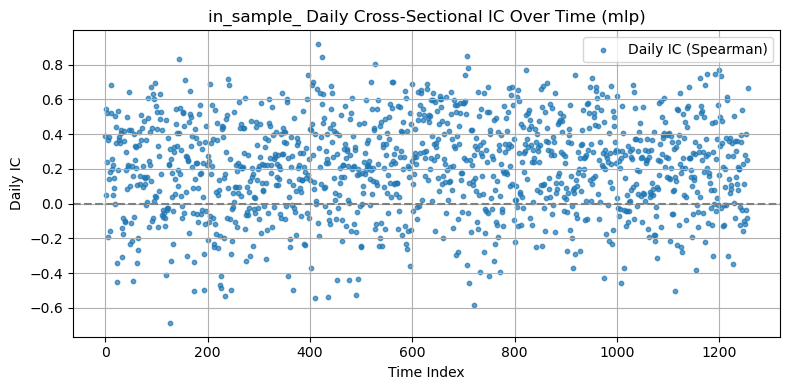

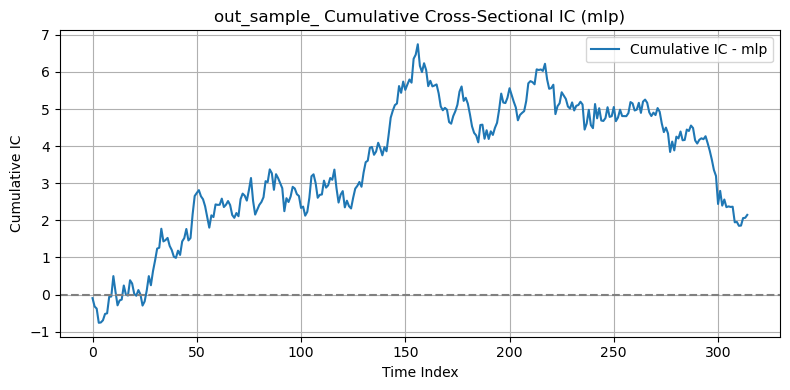

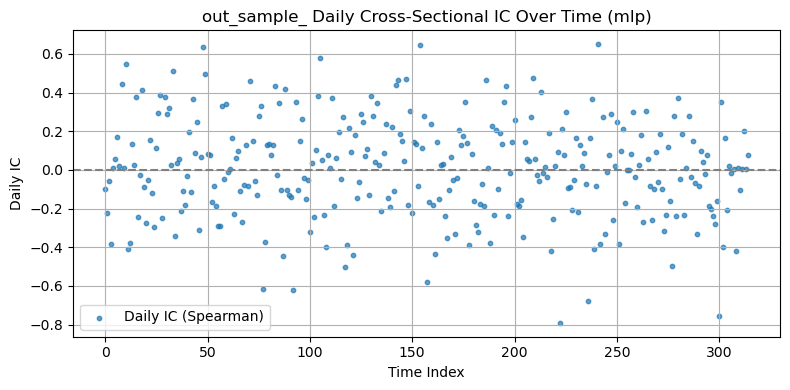

MLP(fixed)分析完成，结果已保存etf_data_processed\mlp_fixed_result


In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV

# 参数路径
processed_data_dir = "etf_data_processed"
mlp_data_dir = os.path.join(processed_data_dir, "mlp_fixed_result")
os.makedirs(mlp_data_dir, exist_ok=True)

# 读取数据
X = pd.read_csv(os.path.join(processed_data_dir, "X_static_window7_scaled.csv"))
Y = pd.read_csv(os.path.join(processed_data_dir, "Y_static_window7.csv"))
target_cols = Y.columns

# 划分数据
n_samples = len(X)
split_idx = int(n_samples * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

# mlp(fixed)
base_mlp = MLPRegressor(hidden_layer_sizes=(128,), max_iter=500, random_state=42)
model_mlp_fixed = MultiOutputRegressor(base_mlp)
model_mlp_fixed.fit(X_train, Y_train)

# 预测
pred_train = model_mlp_fixed.predict(X_train)
pred_test = model_mlp_fixed.predict(X_test)
pred_train_mlp = pd.DataFrame(pred_train, columns=target_cols)
pred_test_mlp = pd.DataFrame(pred_test, columns=target_cols)

# IC
evaluate_ic_metrics(
    pred_df=pred_train_mlp,
    true_df=Y_train.reset_index(drop=True),
    save_dir=mlp_data_dir,
    model_name="mlp",
    prefix="in_sample_"
)

evaluate_ic_metrics(
    pred_df=pred_test_mlp,
    true_df=Y_test.reset_index(drop=True),
    save_dir=mlp_data_dir,
    model_name="mlp",
    prefix="out_sample_"
)

# 误差分析
mse, mae = {}, {}
for col in target_cols:
    mse[col] = mean_squared_error(Y_test[col], pred_test_mlp[col])
    mae[col] = mean_absolute_error(Y_test[col], pred_test_mlp[col])

error_df = pd.DataFrame({"MSE": mse, "MAE": mae})
error_df.to_csv(os.path.join(mlp_data_dir, "mlp_error_metrics.csv"))
joblib.dump(model_mlp_fixed, os.path.join(mlp_data_dir, "mlp_model.pkl"))

print(f"MLP(fixed)分析完成，结果已保存{mlp_data_dir}")


## GRU

Using device: cuda
Epoch 1/30 | Loss: 0.027104
Epoch 2/30 | Loss: 0.012780
Epoch 3/30 | Loss: 0.008543
Epoch 4/30 | Loss: 0.005914
Epoch 5/30 | Loss: 0.004613
Epoch 6/30 | Loss: 0.003744
Epoch 7/30 | Loss: 0.003191
Epoch 8/30 | Loss: 0.002804
Epoch 9/30 | Loss: 0.002515
Epoch 10/30 | Loss: 0.002290
Epoch 11/30 | Loss: 0.002098
Epoch 12/30 | Loss: 0.001982
Epoch 13/30 | Loss: 0.001859
Epoch 14/30 | Loss: 0.001745
Epoch 15/30 | Loss: 0.001697
Epoch 16/30 | Loss: 0.001617
Epoch 17/30 | Loss: 0.001593
Epoch 18/30 | Loss: 0.001530
Epoch 19/30 | Loss: 0.001481
Epoch 20/30 | Loss: 0.001415
Epoch 21/30 | Loss: 0.001394
Epoch 22/30 | Loss: 0.001369
Epoch 23/30 | Loss: 0.001379
Epoch 24/30 | Loss: 0.001343
Epoch 25/30 | Loss: 0.001323
Epoch 26/30 | Loss: 0.001288
Epoch 27/30 | Loss: 0.001306
Epoch 28/30 | Loss: 0.001271
Epoch 29/30 | Loss: 0.001257
Epoch 30/30 | Loss: 0.001230


C:\Users\Lucius\AppData\Local\Temp\ipykernel_30552\2308919543.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(gru_data_dir

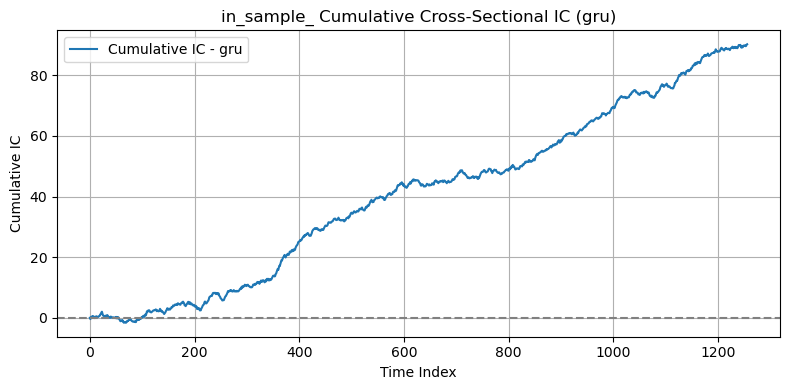

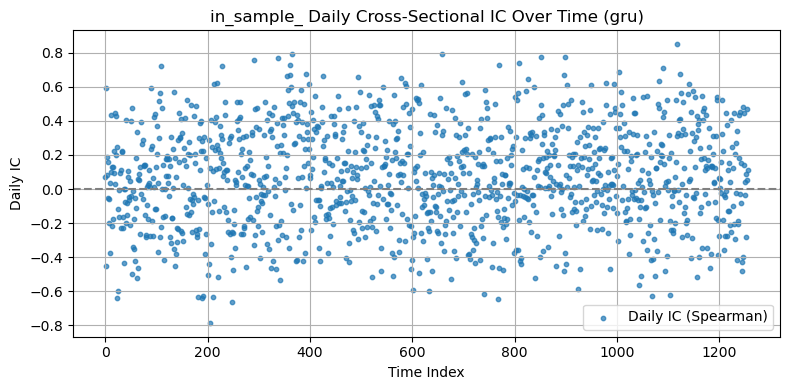

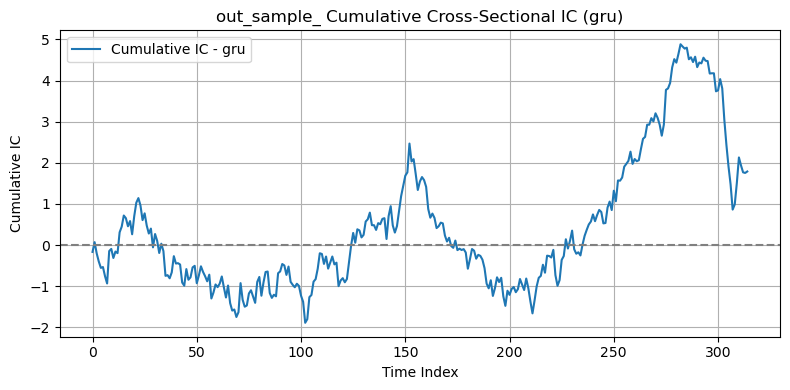

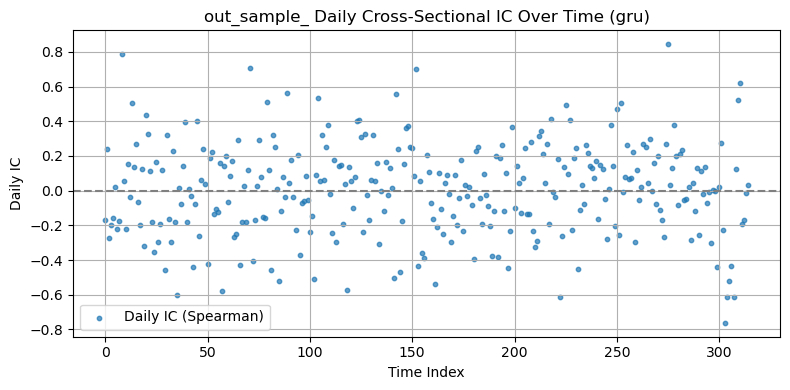

GRU分析完成，结果已保存etf_data_processed\gru_result


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import random

# 设置随机种子以保证复现性
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 路径参数
gru_data_dir = os.path.join(processed_data_dir, "gru_result")
os.makedirs(gru_data_dir, exist_ok=True)

X_seq_path = os.path.join(processed_data_dir, "X_sequence_window7_scaled.npy")
Y_seq_path = os.path.join(processed_data_dir, "Y_sequence_window7.npy")

X_seq = np.load(X_seq_path)
Y_seq = np.load(Y_seq_path)

n_samples, time_steps, n_features = X_seq.shape
n_targets = Y_seq.shape[1]

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 划分训练测试集
split_idx = int(n_samples * 0.8)
X_train = torch.tensor(X_seq[:split_idx], dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_seq[:split_idx], dtype=torch.float32).to(device)
X_test = torch.tensor(X_seq[split_idx:], dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_seq[split_idx:], dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=32, shuffle=False)

# GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

model = GRUModel(input_size=n_features, hidden_size=64, output_size=n_targets).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 模型训练
epochs = 30
best_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.6f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
        torch.save(model.state_dict(), os.path.join(gru_data_dir, "best_gru_model.pt"))
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# 载入最佳模型
model.load_state_dict(torch.load(os.path.join(gru_data_dir, "best_gru_model.pt")))

# 预测与评估
def predict(model, dataloader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in dataloader:
            pred = model(xb).cpu().numpy()
            all_preds.append(pred)
    return np.vstack(all_preds)

pred_train_gru = predict(model, train_loader)
pred_test_gru = predict(model, test_loader)

# 输出
return_df = pd.read_csv(os.path.join(processed_data_dir, "etf_feature_matrix.csv"))
target_cols = [col for col in return_df.columns if col.endswith("_return")]
pred_df_train_gru = pd.DataFrame(pred_train_gru, columns=target_cols)
pred_df_test_gru = pd.DataFrame(pred_test_gru, columns=target_cols)
Y_train_df_gru = pd.DataFrame(Y_train.cpu().numpy(), columns=target_cols)
Y_test_df_gru = pd.DataFrame(Y_test.cpu().numpy(), columns=target_cols)

# IC
evaluate_ic_metrics(pred_df_train_gru, Y_train_df_gru, save_dir=gru_data_dir, model_name="gru", prefix="in_sample_")
evaluate_ic_metrics(pred_df_test_gru, Y_test_df_gru, save_dir=gru_data_dir, model_name="gru", prefix="out_sample_")

# 误差评估
mse, mae = {}, {}
for col in target_cols:
    mse[col] = mean_squared_error(Y_test_df_gru[col], pred_df_test_gru[col])
    mae[col] = mean_absolute_error(Y_test_df_gru[col], pred_df_test_gru[col])

error_df = pd.DataFrame({"MSE": mse, "MAE": mae})
error_df.to_csv(os.path.join(gru_data_dir, "gru_error_metrics.csv"))
print(f"GRU分析完成，结果已保存{gru_data_dir}")

## LSTM

Using device: cuda
Epoch 1/30 | Loss: 0.009998
Epoch 2/30 | Loss: 0.004582
Epoch 3/30 | Loss: 0.003069
Epoch 4/30 | Loss: 0.002443
Epoch 5/30 | Loss: 0.002139
Epoch 6/30 | Loss: 0.001937
Epoch 7/30 | Loss: 0.001800
Epoch 8/30 | Loss: 0.001666
Epoch 9/30 | Loss: 0.001591
Epoch 10/30 | Loss: 0.001546
Epoch 11/30 | Loss: 0.001473
Epoch 12/30 | Loss: 0.001426
Epoch 13/30 | Loss: 0.001388
Epoch 14/30 | Loss: 0.001367
Epoch 15/30 | Loss: 0.001358
Epoch 16/30 | Loss: 0.001318
Epoch 17/30 | Loss: 0.001273
Epoch 18/30 | Loss: 0.001274
Epoch 19/30 | Loss: 0.001248
Epoch 20/30 | Loss: 0.001216
Epoch 21/30 | Loss: 0.001207
Epoch 22/30 | Loss: 0.001145
Epoch 23/30 | Loss: 0.001210
Epoch 24/30 | Loss: 0.001139
Epoch 25/30 | Loss: 0.001060
Epoch 26/30 | Loss: 0.001075
Epoch 27/30 | Loss: 0.001054
Epoch 28/30 | Loss: 0.001004
Epoch 29/30 | Loss: 0.000954
Epoch 30/30 | Loss: 0.000942


C:\Users\Lucius\AppData\Local\Temp\ipykernel_30552\2993946923.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lstm.load_state_dict(torch.load(os.path.join(lstm_da

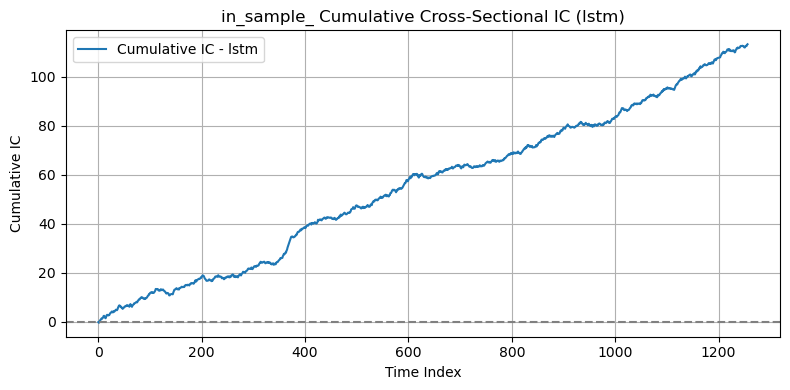

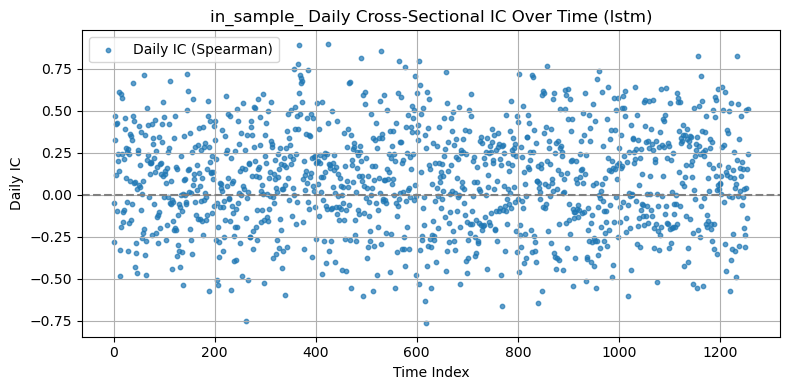

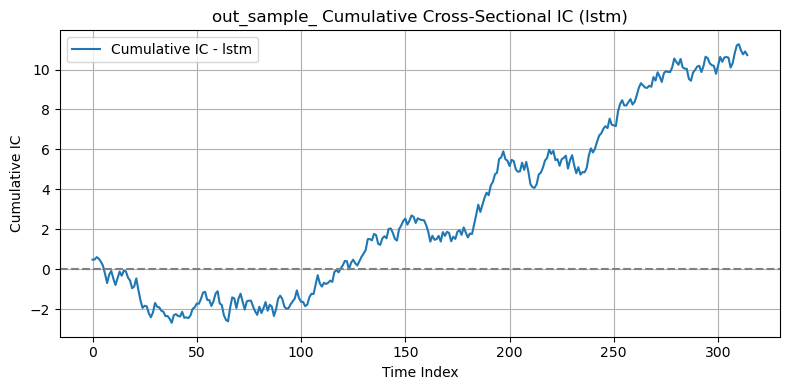

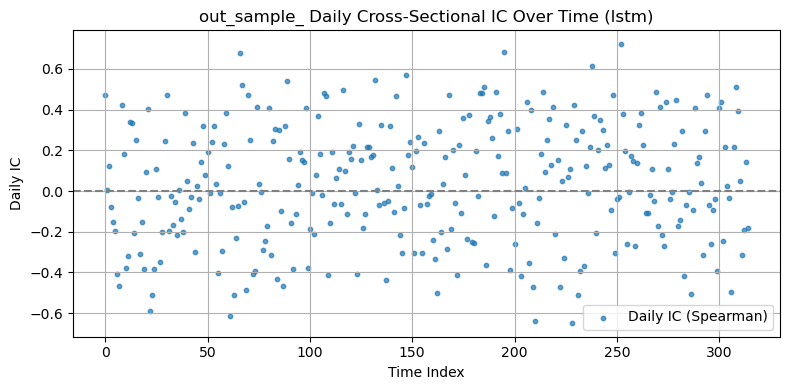

LSTM分析完成，结果已保存etf_data_processed\lstm_result


In [6]:
from torch.utils.data import DataLoader, TensorDataset

# 设置随机种子以保证复现性
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 路径参数
lstm_data_dir = os.path.join(processed_data_dir, "lstm_result")
os.makedirs(lstm_data_dir, exist_ok=True)

X_lstm_seq_path = os.path.join(processed_data_dir, "X_sequence_window7_scaled.npy")
Y_lstm_seq_path = os.path.join(processed_data_dir, "Y_sequence_window7.npy")

X_lstm_seq = np.load(X_lstm_seq_path)
Y_lstm_seq = np.load(Y_lstm_seq_path)

n_lstm_samples, lstm_time_steps, lstm_n_features = X_lstm_seq.shape
lstm_n_targets = Y_lstm_seq.shape[1]

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 划分训练测试集
lstm_split_idx = int(n_lstm_samples * 0.8)
X_lstm_train = torch.tensor(X_lstm_seq[:lstm_split_idx], dtype=torch.float32).to(device)
Y_lstm_train = torch.tensor(Y_lstm_seq[:lstm_split_idx], dtype=torch.float32).to(device)
X_lstm_test = torch.tensor(X_lstm_seq[lstm_split_idx:], dtype=torch.float32).to(device)
Y_lstm_test = torch.tensor(Y_lstm_seq[lstm_split_idx:], dtype=torch.float32).to(device)

lstm_train_loader = DataLoader(TensorDataset(X_lstm_train, Y_lstm_train), batch_size=32, shuffle=False)
lstm_test_loader = DataLoader(TensorDataset(X_lstm_test, Y_lstm_test), batch_size=32, shuffle=False)

# LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

model_lstm = LSTMModel(input_size=lstm_n_features, hidden_size=64, output_size=lstm_n_targets).to(device)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
loss_fn_lstm = nn.MSELoss()

# 模型训练
lstm_epochs = 30
best_lstm_loss = float('inf')
lstm_patience = 5
lstm_counter = 0

for epoch in range(lstm_epochs):
    model_lstm.train()
    running_lstm_loss = 0.0
    for xb, yb in lstm_train_loader:
        pred = model_lstm(xb)
        loss = loss_fn_lstm(pred, yb)
        optimizer_lstm.zero_grad()
        loss.backward()
        optimizer_lstm.step()
        running_lstm_loss += loss.item() * xb.size(0)

    epoch_lstm_loss = running_lstm_loss / len(lstm_train_loader.dataset)
    print(f"Epoch {epoch+1}/{lstm_epochs} | Loss: {epoch_lstm_loss:.6f}")

    if epoch_lstm_loss < best_lstm_loss:
        best_lstm_loss = epoch_lstm_loss
        lstm_counter = 0
        torch.save(model_lstm.state_dict(), os.path.join(lstm_data_dir, "best_lstm_model.pt"))
    else:
        lstm_counter += 1
        if lstm_counter >= lstm_patience:
            print("Early stopping triggered")
            break

# 载入最佳模型
model_lstm.load_state_dict(torch.load(os.path.join(lstm_data_dir, "best_lstm_model.pt")))

# 预测与评估
def predict_lstm(model, dataloader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in dataloader:
            pred = model(xb).cpu().numpy()
            all_preds.append(pred)
    return np.vstack(all_preds)

pred_train_lstm = predict_lstm(model_lstm, lstm_train_loader)
pred_test_lstm = predict_lstm(model_lstm, lstm_test_loader)

# 输出
return_df = pd.read_csv(os.path.join(processed_data_dir, "etf_feature_matrix.csv"))
target_cols = [col for col in return_df.columns if col.endswith("_return")]
pred_df_train_lstm = pd.DataFrame(pred_train_lstm, columns=target_cols)
pred_df_test_lstm = pd.DataFrame(pred_test_lstm, columns=target_cols)
Y_train_df_lstm = pd.DataFrame(Y_lstm_train.cpu().numpy(), columns=target_cols)
Y_test_df_lstm = pd.DataFrame(Y_lstm_test.cpu().numpy(), columns=target_cols)

# IC
evaluate_ic_metrics(pred_df_train_lstm, Y_train_df_lstm, save_dir=lstm_data_dir, model_name="lstm", prefix="in_sample_")
evaluate_ic_metrics(pred_df_test_lstm, Y_test_df_lstm, save_dir=lstm_data_dir, model_name="lstm", prefix="out_sample_")

# 误差评估
mse_lstm, mae_lstm = {}, {}
for col in target_cols:
    mse_lstm[col] = mean_squared_error(Y_test_df_lstm[col], pred_df_test_lstm[col])
    mae_lstm[col] = mean_absolute_error(Y_test_df_lstm[col], pred_df_test_lstm[col])

error_df_lstm = pd.DataFrame({"MSE": mse_lstm, "MAE": mae_lstm})
error_df_lstm.to_csv(os.path.join(lstm_data_dir, "lstm_error_metrics.csv"))
print(f"LSTM分析完成，结果已保存{lstm_data_dir}")

## Transformer

Using device: cuda
Epoch 1/100 | Loss: 0.065544
Epoch 2/100 | Loss: 0.022517
Epoch 3/100 | Loss: 0.014025
Epoch 4/100 | Loss: 0.009194
Epoch 5/100 | Loss: 0.006880
Epoch 6/100 | Loss: 0.005545
Epoch 7/100 | Loss: 0.004726
Epoch 8/100 | Loss: 0.004265
Epoch 9/100 | Loss: 0.003855
Epoch 10/100 | Loss: 0.003489
Epoch 11/100 | Loss: 0.003340
Epoch 12/100 | Loss: 0.003219
Epoch 13/100 | Loss: 0.003045
Epoch 14/100 | Loss: 0.002939
Epoch 15/100 | Loss: 0.002825
Epoch 16/100 | Loss: 0.002788
Epoch 17/100 | Loss: 0.002674
Epoch 18/100 | Loss: 0.002605
Epoch 19/100 | Loss: 0.002568
Epoch 20/100 | Loss: 0.002506
Epoch 21/100 | Loss: 0.002479
Epoch 22/100 | Loss: 0.002397
Epoch 23/100 | Loss: 0.002358
Epoch 24/100 | Loss: 0.002220
Epoch 25/100 | Loss: 0.002216
Epoch 26/100 | Loss: 0.002213
Epoch 27/100 | Loss: 0.002156
Epoch 28/100 | Loss: 0.002090
Epoch 29/100 | Loss: 0.002043
Epoch 30/100 | Loss: 0.002028
Epoch 31/100 | Loss: 0.002012
Epoch 32/100 | Loss: 0.002067
Epoch 33/100 | Loss: 0.001985


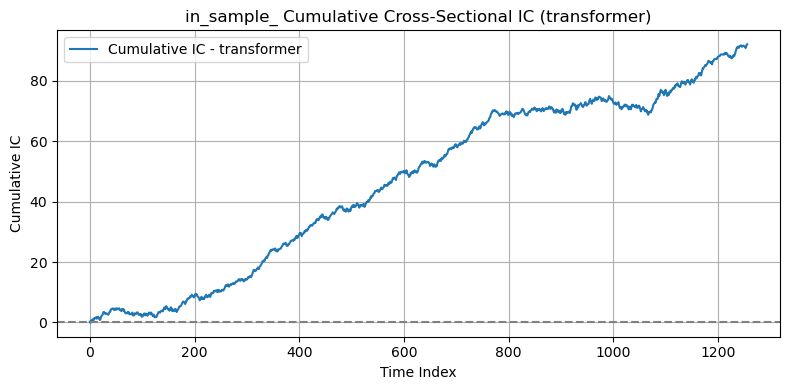

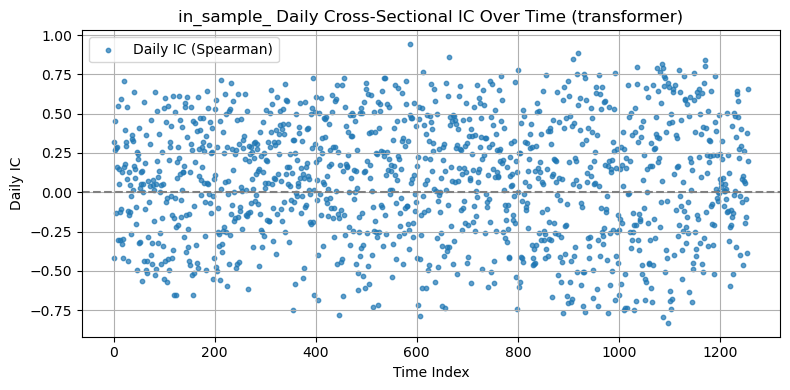

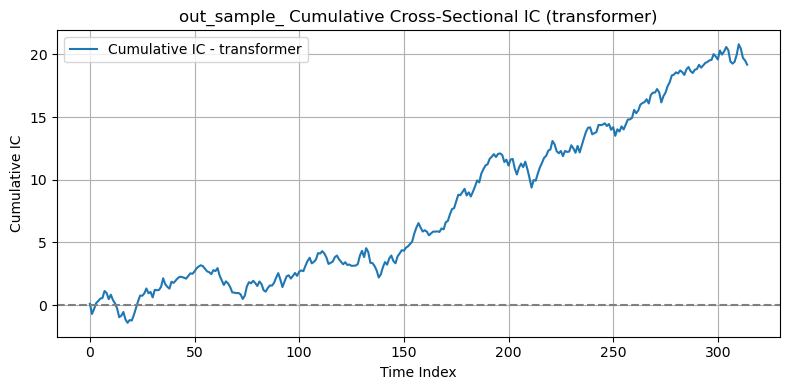

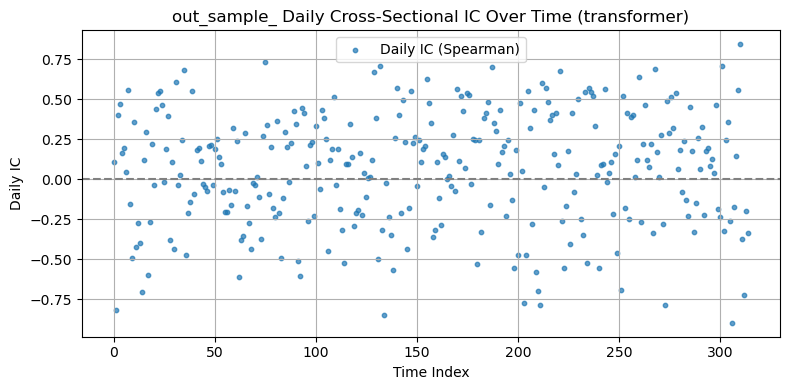

Transformer分析完成，结果已保存etf_data_processed\transformer_result


In [7]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import random

# 设置随机种子 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 路径参数 
trans_dir = os.path.join(processed_data_dir, "transformer_result")
os.makedirs(trans_dir, exist_ok=True)

X_seq = np.load(os.path.join(processed_data_dir, "X_sequence_window7_scaled.npy"))
Y_seq = np.load(os.path.join(processed_data_dir, "Y_sequence_window7.npy"))

n_samples, time_steps, n_features = X_seq.shape
n_targets = Y_seq.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据划分 
split_idx = int(n_samples * 0.8)
X_train = torch.tensor(X_seq[:split_idx], dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_seq[:split_idx], dtype=torch.float32).to(device)
X_test = torch.tensor(X_seq[split_idx:], dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_seq[split_idx:], dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=32, shuffle=False)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# Transformer with Causal Mask
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(model_dim, output_dim)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)

        # 添加因果 mask（防止模型看到未来）
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)

        x = self.transformer(x, mask=mask)
        x = x[:, -1, :]  # 取最后一个时间步
        return self.output_fc(x)

model_trans = TransformerModel(
    input_dim=n_features,
    model_dim=128,
    num_heads=8,
    num_layers=3,
    output_dim=n_targets,
    dropout=0.2
).to(device)

optimizer = torch.optim.AdamW(model_trans.parameters(), lr=5e-4, weight_decay=1e-2)
loss_fn = nn.MSELoss()

# 模型训练
epochs = 100
for epoch in range(epochs):
    model_trans.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model_trans(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

# 保存最终模型
torch.save(model_trans.state_dict(), os.path.join(trans_dir, "final_transformer_model.pt"))

# 评估
def predict(model, dataloader):
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in dataloader:
            out = model(xb).cpu().numpy()
            preds.append(out)
    return np.vstack(preds)

pred_train_trans = predict(model_trans, train_loader)
pred_test_trans = predict(model_trans, test_loader)

return_df = pd.read_csv(os.path.join(processed_data_dir, "etf_feature_matrix.csv"))
target_cols = [col for col in return_df.columns if col.endswith("_return")]
pred_df_train_trans = pd.DataFrame(pred_train_trans, columns=target_cols)
pred_df_test_trans = pd.DataFrame(pred_test_trans, columns=target_cols)
Y_train_df_trans = pd.DataFrame(Y_train.cpu().numpy(), columns=target_cols)
Y_test_df_trans = pd.DataFrame(Y_test.cpu().numpy(), columns=target_cols)

evaluate_ic_metrics(pred_df_train_trans, Y_train_df_trans, save_dir=trans_dir, model_name="transformer", prefix="in_sample_")
evaluate_ic_metrics(pred_df_test_trans, Y_test_df_trans, save_dir=trans_dir, model_name="transformer", prefix="out_sample_")

mse, mae = {}, {}
for col in target_cols:
    mse[col] = mean_squared_error(Y_test_df_trans[col], pred_df_test_trans[col])
    mae[col] = mean_absolute_error(Y_test_df_trans[col], pred_df_test_trans[col])

error_df = pd.DataFrame({"MSE": mse, "MAE": mae})
error_df.to_csv(os.path.join(trans_dir, "transformer_error_metrics.csv"))
print(f"Transformer分析完成，结果已保存{trans_dir}")


## CNN

Using device: cuda
Epoch 1/50 | Loss: 0.141429
Epoch 2/50 | Loss: 0.041773
Epoch 3/50 | Loss: 0.024259
Epoch 4/50 | Loss: 0.017786
Epoch 5/50 | Loss: 0.013211
Epoch 6/50 | Loss: 0.010630
Epoch 7/50 | Loss: 0.008825
Epoch 8/50 | Loss: 0.007298
Epoch 9/50 | Loss: 0.006247
Epoch 10/50 | Loss: 0.005199
Epoch 11/50 | Loss: 0.004695
Epoch 12/50 | Loss: 0.004165
Epoch 13/50 | Loss: 0.003709
Epoch 14/50 | Loss: 0.003332
Epoch 15/50 | Loss: 0.003095
Epoch 16/50 | Loss: 0.002739
Epoch 17/50 | Loss: 0.002506
Epoch 18/50 | Loss: 0.002341
Epoch 19/50 | Loss: 0.002183
Epoch 20/50 | Loss: 0.002061
Epoch 21/50 | Loss: 0.001934
Epoch 22/50 | Loss: 0.001826
Epoch 23/50 | Loss: 0.001752
Epoch 24/50 | Loss: 0.001668
Epoch 25/50 | Loss: 0.001604
Epoch 26/50 | Loss: 0.001584
Epoch 27/50 | Loss: 0.001531
Epoch 28/50 | Loss: 0.001464
Epoch 29/50 | Loss: 0.001461
Epoch 30/50 | Loss: 0.001407
Epoch 31/50 | Loss: 0.001364
Epoch 32/50 | Loss: 0.001373
Epoch 33/50 | Loss: 0.001349
Epoch 34/50 | Loss: 0.001314
Epoc

C:\Users\Lucius\AppData\Local\Temp\ipykernel_30552\487282643.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load(os.path.join(cnn_data_

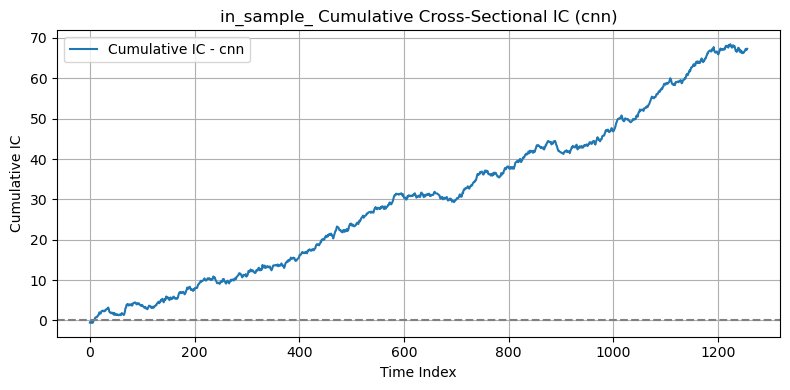

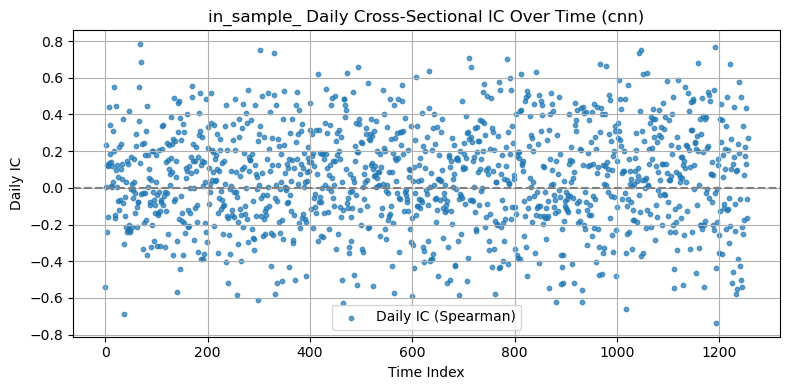

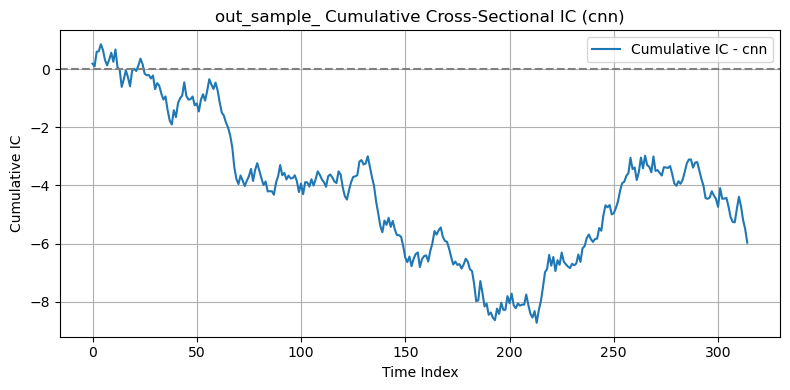

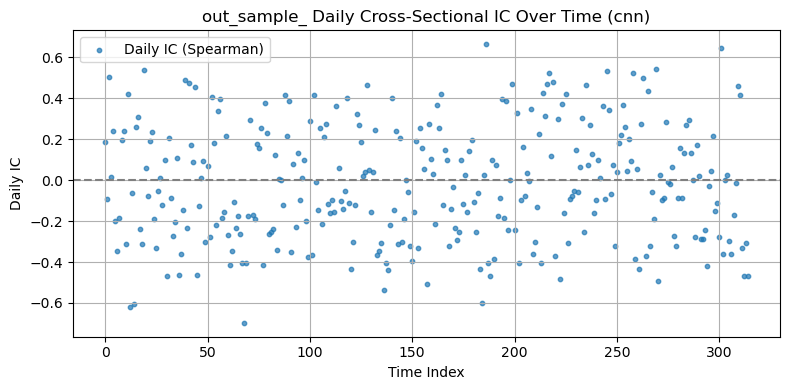

CNN分析完成，结果已保存etf_data_processed\cnn_result


In [8]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

# 设置随机种子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 路径参数
processed_data_dir = "etf_data_processed"
cnn_data_dir = os.path.join(processed_data_dir, "cnn_result")
os.makedirs(cnn_data_dir, exist_ok=True)

X_seq_cnn = np.load(os.path.join(processed_data_dir, "X_sequence_window7_scaled.npy"))
Y_seq_cnn = np.load(os.path.join(processed_data_dir, "Y_sequence_window7.npy"))

n_samples_cnn, time_steps_cnn, n_features_cnn = X_seq_cnn.shape
n_targets_cnn = Y_seq_cnn.shape[1]

# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据分割
split_idx_cnn = int(n_samples_cnn * 0.8)
X_train_cnn = torch.tensor(X_seq_cnn[:split_idx_cnn], dtype=torch.float32).to(device)
Y_train_cnn = torch.tensor(Y_seq_cnn[:split_idx_cnn], dtype=torch.float32).to(device)
X_test_cnn = torch.tensor(X_seq_cnn[split_idx_cnn:], dtype=torch.float32).to(device)
Y_test_cnn = torch.tensor(Y_seq_cnn[split_idx_cnn:], dtype=torch.float32).to(device)

train_loader_cnn = DataLoader(TensorDataset(X_train_cnn, Y_train_cnn), batch_size=32, shuffle=False)
test_loader_cnn = DataLoader(TensorDataset(X_test_cnn, Y_test_cnn), batch_size=32, shuffle=False)

# CNN
class CNNModel(nn.Module):
    def __init__(self, input_channels, time_steps, num_features, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, num_features), padding=(1, 0))
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(16, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.relu(self.conv1(x)) 
        x = self.pool(x).squeeze(-1).squeeze(-1) 
        x = self.dropout(x)
        return self.fc(x)

model_cnn = CNNModel(input_channels=1, time_steps=time_steps_cnn, num_features=n_features_cnn, output_size=n_targets_cnn).to(device)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
loss_fn_cnn = nn.MSELoss()

# 训练
epochs_cnn = 50
best_loss_cnn = float('inf')
patience_cnn = 5
counter_cnn = 0

for epoch in range(epochs_cnn):
    model_cnn.train()
    total_loss_cnn = 0
    for xb, yb in train_loader_cnn:
        pred = model_cnn(xb)
        loss = loss_fn_cnn(pred, yb)
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        total_loss_cnn += loss.item() * xb.size(0)

    avg_loss_cnn = total_loss_cnn / len(train_loader_cnn.dataset)
    print(f"Epoch {epoch+1}/{epochs_cnn} | Loss: {avg_loss_cnn:.6f}")

    if avg_loss_cnn < best_loss_cnn:
        best_loss_cnn = avg_loss_cnn
        counter_cnn = 0
        torch.save(model_cnn.state_dict(), os.path.join(cnn_data_dir, "best_cnn_model.pt"))
    else:
        counter_cnn += 1
        if counter_cnn >= patience_cnn:
            print("Early stopping triggered")
            break

# 载入最佳模型
model_cnn.load_state_dict(torch.load(os.path.join(cnn_data_dir, "best_cnn_model.pt")))

def predict_cnn(model, dataloader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in dataloader:
            pred = model(xb).cpu().numpy()
            all_preds.append(pred)
    return np.vstack(all_preds)

pred_train_cnn = predict_cnn(model_cnn, train_loader_cnn)
pred_test_cnn = predict_cnn(model_cnn, test_loader_cnn)

return_df = pd.read_csv(os.path.join(processed_data_dir, "etf_feature_matrix.csv"))
target_cols = [col for col in return_df.columns if col.endswith("_return")]
pred_df_train_cnn = pd.DataFrame(pred_train_cnn, columns=target_cols)
pred_df_test_cnn = pd.DataFrame(pred_test_cnn, columns=target_cols)
Y_train_df_cnn = pd.DataFrame(Y_train_cnn.cpu().numpy(), columns=target_cols)
Y_test_df_cnn = pd.DataFrame(Y_test_cnn.cpu().numpy(), columns=target_cols)

evaluate_ic_metrics(pred_df_train_cnn, Y_train_df_cnn, save_dir=cnn_data_dir, model_name="cnn", prefix="in_sample_")
evaluate_ic_metrics(pred_df_test_cnn, Y_test_df_cnn, save_dir=cnn_data_dir, model_name="cnn", prefix="out_sample_")

mse_cnn, mae_cnn = {}, {}
for col in target_cols:
    mse_cnn[col] = mean_squared_error(Y_test_df_cnn[col], pred_df_test_cnn[col])
    mae_cnn[col] = mean_absolute_error(Y_test_df_cnn[col], pred_df_test_cnn[col])

error_df_cnn = pd.DataFrame({"MSE": mse_cnn, "MAE": mae_cnn})
error_df_cnn.to_csv(os.path.join(cnn_data_dir, "cnn_error_metrics.csv"))
print(f"CNN分析完成，结果已保存{cnn_data_dir}")


## HGBM

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


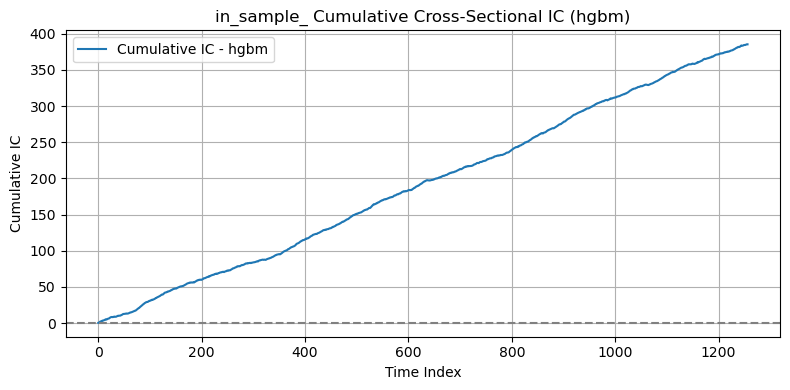

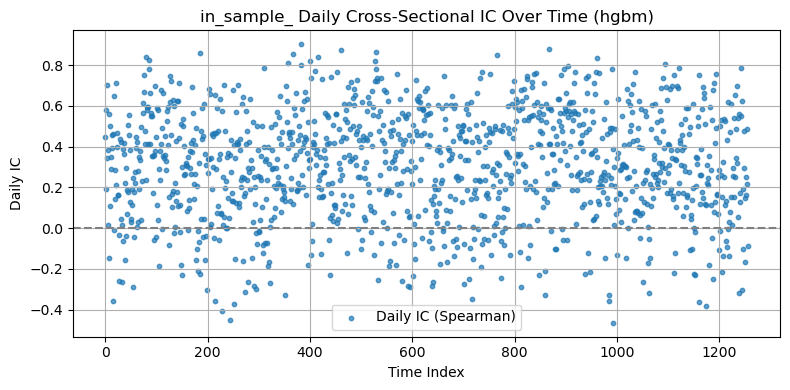

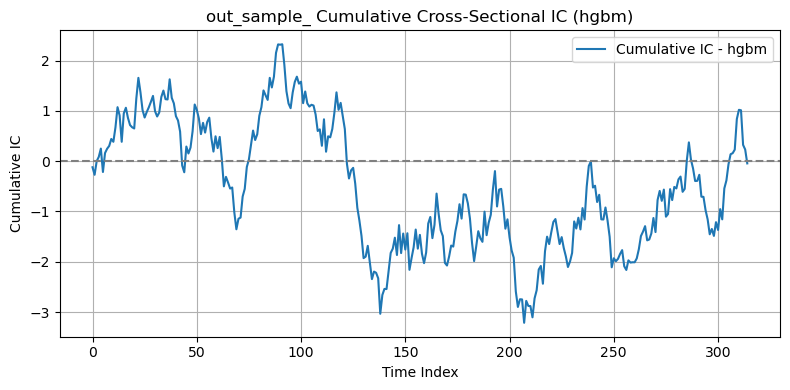

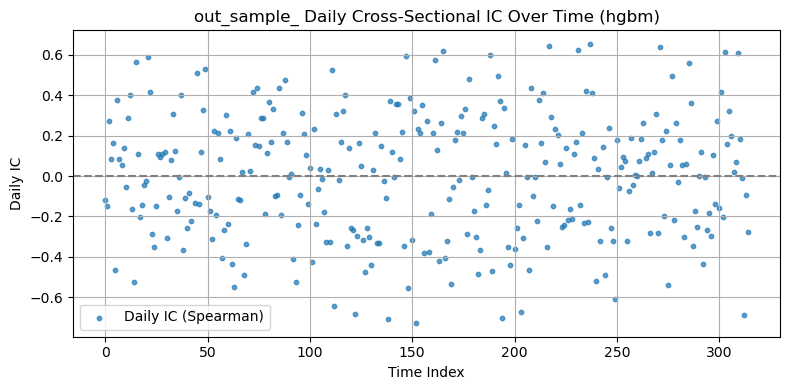

HistGradientBoosting分析完成，结果已保存 etf_data_processed\hgbm_result


In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# 路径设置 
processed_data_dir = "etf_data_processed"
hgbm_data_dir = os.path.join(processed_data_dir, "hgbm_result")
os.makedirs(hgbm_data_dir, exist_ok=True)

# 数据加载 
X = pd.read_csv(os.path.join(processed_data_dir, "X_static_window7_scaled.csv"))
Y = pd.read_csv(os.path.join(processed_data_dir, "Y_static_window7.csv"))
target_cols = Y.columns

# 数据划分 
n_samples = len(X)
split_idx = int(n_samples * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
Y_train = Y.iloc[:split_idx]
Y_test = Y.iloc[split_idx:]

# 随机搜索调参 
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [15, 31, 63],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.0, 0.1, 1.0],
    'max_depth': [3, 5, None],
    'random_state': [42]
}

base_model = HistGradientBoostingRegressor()
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1
)

model_hgb = MultiOutputRegressor(random_search)
model_hgb.fit(X_train, Y_train)

# 预测 
pred_train = model_hgb.predict(X_train)
pred_test = model_hgb.predict(X_test)
pred_train_df = pd.DataFrame(pred_train, columns=target_cols)
pred_test_df = pd.DataFrame(pred_test, columns=target_cols)

# IC评估 
evaluate_ic_metrics(
    pred_df=pred_train_df,
    true_df=Y_train.reset_index(drop=True),
    save_dir=hgbm_data_dir,
    model_name="hgbm",
    prefix="in_sample_"
)

evaluate_ic_metrics(
    pred_df=pred_test_df,
    true_df=Y_test.reset_index(drop=True),
    save_dir=hgbm_data_dir,
    model_name="hgbm",
    prefix="out_sample_"
)

# 误差评估 
mse, mae = {}, {}
for col in target_cols:
    mse[col] = mean_squared_error(Y_test[col], pred_test_df[col])
    mae[col] = mean_absolute_error(Y_test[col], pred_test_df[col])

error_df = pd.DataFrame({"MSE": mse, "MAE": mae})
error_df.to_csv(os.path.join(hgbm_data_dir, "hgbm_error_metrics.csv"))

# 保存模型 
joblib.dump(model_hgb, os.path.join(hgbm_data_dir, "hgbm_model.pkl"))

print(f"HistGradientBoosting分析完成，结果已保存 {hgbm_data_dir}")


## Stacking

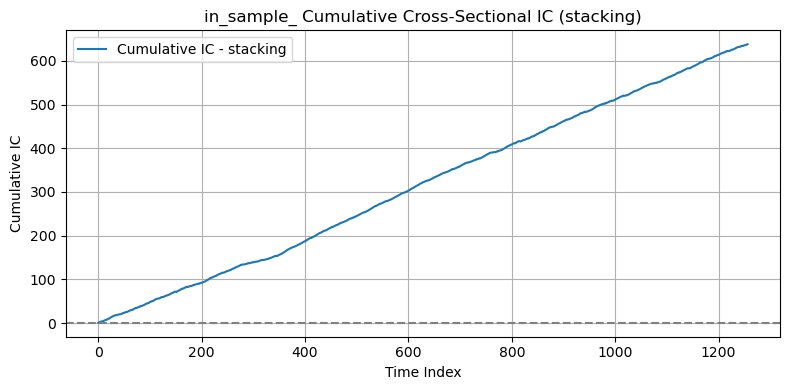

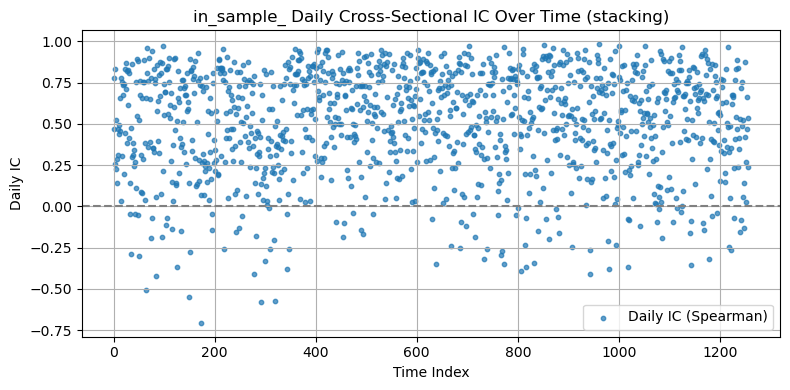

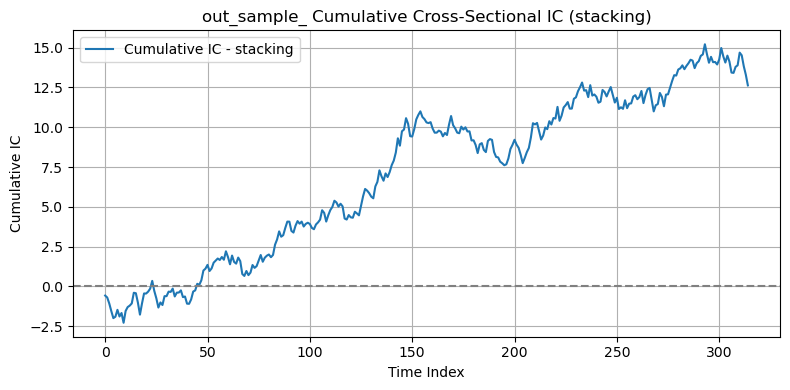

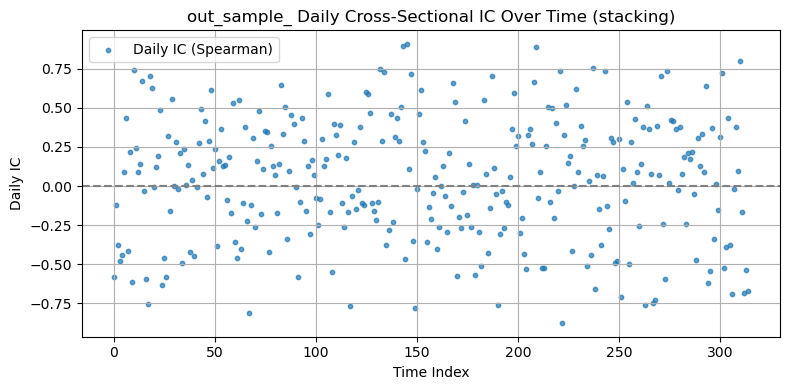

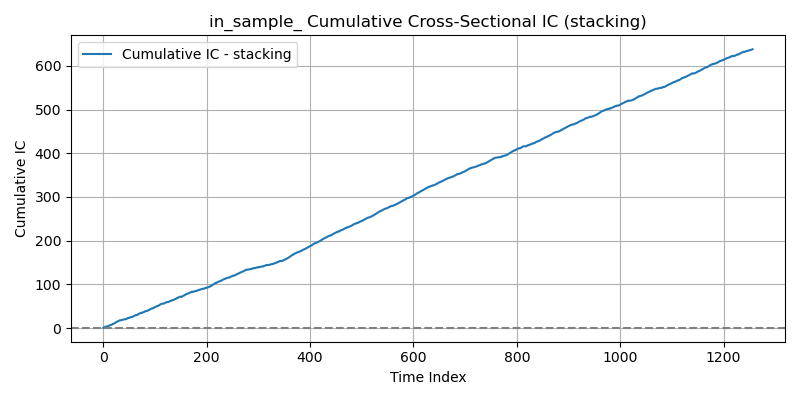

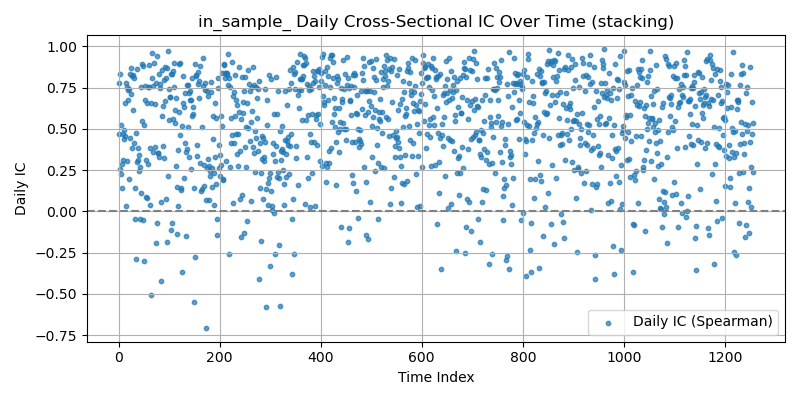

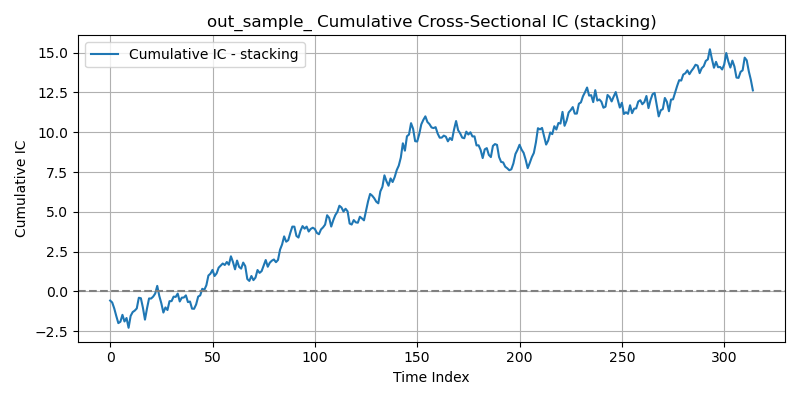

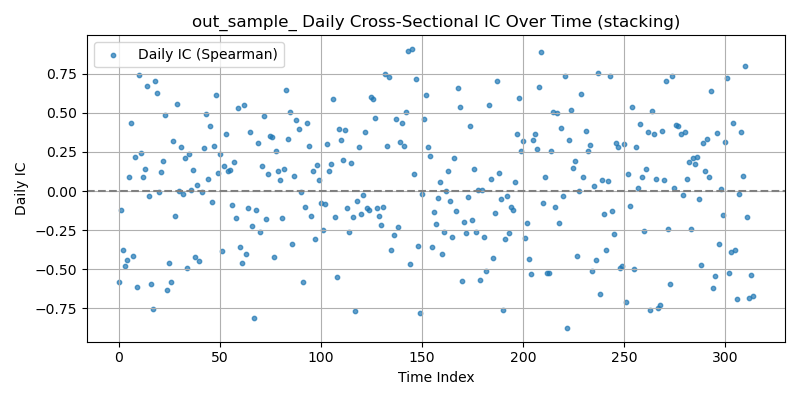

Stacking 融合分析完成，结果已保存至 etf_data_processed\stacking_result


In [10]:
from sklearn.linear_model import Ridge
from IPython.display import Image, display

# 设置路径
processed_data_dir = "etf_data_processed"
stacking_dir = os.path.join(processed_data_dir, "stacking_result")
os.makedirs(stacking_dir, exist_ok=True)

# 构建 stacking 特征（已存在的 out-of-sample 预测）
X_train_stack = pd.concat([
    pred_df_train_trans.add_suffix("_trans"),
    pred_df_train_lstm.add_suffix("_lstm"),
    pred_train_mlp.add_suffix("_mlp")
], axis=1)

X_test_stack = pd.concat([
    pred_df_test_trans.add_suffix("_trans"),
    pred_df_test_lstm.add_suffix("_lstm"),
    pred_test_mlp.add_suffix("_mlp")
], axis=1)

# 标签（统一）
Y_train_stack = Y_train_df_trans.reset_index(drop=True)
Y_test_stack = Y_test_df_trans.reset_index(drop=True)
target_cols = Y_train_stack.columns

# 建模
model_stack = Ridge(alpha=1.0)
model_stack.fit(X_train_stack, Y_train_stack)

# 预测
pred_train_stack = pd.DataFrame(model_stack.predict(X_train_stack), columns=target_cols)
pred_test_stack = pd.DataFrame(model_stack.predict(X_test_stack), columns=target_cols)

# IC 评估
evaluate_ic_metrics(pred_train_stack, Y_train_stack, save_dir=stacking_dir, model_name="stacking", prefix="in_sample_")
evaluate_ic_metrics(pred_test_stack, Y_test_stack, save_dir=stacking_dir, model_name="stacking", prefix="out_sample_")

display(Image(os.path.join(stacking_dir, "in_sample_stacking_cum_ic.png")))
display(Image(os.path.join(stacking_dir, "in_sample_stacking_daily_ic.png")))
display(Image(os.path.join(stacking_dir, "out_sample_stacking_cum_ic.png")))
display(Image(os.path.join(stacking_dir, "out_sample_stacking_daily_ic.png")))

# 误差评估
mse, mae = {}, {}
for col in target_cols:
    mse[col] = mean_squared_error(Y_test_stack[col], pred_test_stack[col])
    mae[col] = mean_absolute_error(Y_test_stack[col], pred_test_stack[col])

error_df = pd.DataFrame({"MSE": mse, "MAE": mae})
error_df.to_csv(os.path.join(stacking_dir, "stacking_error_metrics.csv"))

# 模型保存
joblib.dump(model_stack, os.path.join(stacking_dir, "stacking_model.pkl"))

print(f"Stacking 融合分析完成，结果已保存至 {stacking_dir}")
